# Intro to TRFL and OpenAI Gym

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint

For google colab display:

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1007'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1007'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Part 1: Intro to OpenAI Gym with Tabular Q-learning

### 1.1 What is Gym, and why?

*"Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball."*

Gym only contains **environments** that you can interact with; it does not contain any Reinforcement Learning algorithms (or other techniques to write agents).

People use Gym because:
- It's (very) **easy to set up**
- It provides a variety of **diverse environments**, some are easy benchmarks, some are hard (atari games...)
- It allows fair **comparisons**: researcher can benchmark their techniques on known environments used by everyone.

### 1.2 Installing

In [3]:
!pip install gym
# !pip install gym[atari]

In [5]:
import gym

### 1.3 Overview of the environments, FrozenLake

#### 1.3.1 Environments

**Listing environments:**

Gym contains a lot of environments, all of which are listed in the env registry:

In [5]:
pprint(list(gym.envs.registry.all())[:20])

[EnvSpec(Copy-v0),
 EnvSpec(RepeatCopy-v0),
 EnvSpec(ReversedAddition-v0),
 EnvSpec(ReversedAddition3-v0),
 EnvSpec(DuplicatedInput-v0),
 EnvSpec(Reverse-v0),
 EnvSpec(CartPole-v0),
 EnvSpec(CartPole-v1),
 EnvSpec(MountainCar-v0),
 EnvSpec(MountainCarContinuous-v0),
 EnvSpec(Pendulum-v0),
 EnvSpec(Acrobot-v1),
 EnvSpec(LunarLander-v2),
 EnvSpec(LunarLanderContinuous-v2),
 EnvSpec(BipedalWalker-v2),
 EnvSpec(BipedalWalkerHardcore-v2),
 EnvSpec(CarRacing-v0),
 EnvSpec(Blackjack-v0),
 EnvSpec(KellyCoinflip-v0),
 EnvSpec(KellyCoinflipGeneralized-v0)]


In [6]:
len(list(gym.envs.registry.all()))

797

Some environments are shown on gym's homepage: https://gym.openai.com/

**Loading an environment:**

In [9]:
env = gym.make('MountainCarContinuous-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


**Rendering:**

On a local machine, the following code would open up a window with the game:

In [ ]:
# env.render()
# env.close()

Here's a trick to plot the current state of the game right in jupyter:

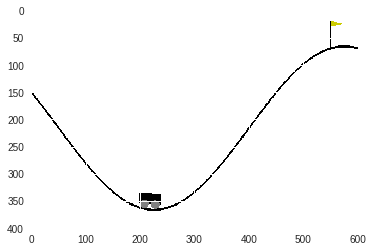

In [12]:
screen = env.render(mode='rgb_array')
plt.imshow(screen)
ipythondisplay.clear_output(wait=True)

**Action space and observation space**

Besides the pixels of the game, Gym actually gives you access to two important objects: actions that you can take, and observations (state of the game). Both actions and observations can be either discrete or continuous, depending on the game.

In [ ]:
env.action_space, env.observation_space

(Box(1,), Box(2,))

Here, the action space is continuous: one number, ranging from +1 (go right) to -1 (go left).

The observation space is also continuous: the position of the car (x) and its velocity (x').

**Interacting with the environment, getting rewards**

Every Gym environment has a method step() that takes as argument the index of the action to take, and outputs the new state, the reward for taking this action, and tells us whether the game is done or not (here: if we reached the goal).

#### 1.3.2 FrozenLake

In [12]:
# 1. Load Environment and Q-table structure
env = gym.make('FrozenLake-v0')
print('states: ', env.observation_space)
print('actions: ', env.action_space)
env.reset()
env.render()

states:  Discrete(16)
actions:  Discrete(4)

SFFF
FHFH
FFFH
HFFG


In this environment aim is to reach the goal G, on a frozen lake that might have some holes in it. Since the lake is frozen, **your actions are non deterministic**: you may try to go left and go down instead for example.

S: starting point (safe), F: frozen surface (safe), H: hole (fall to your doom), G: goal (where the frisbee is located)

- The environment is a grid of shape 4x4. Each state is a position on this grid (so 16 states), some are just frozen, some are holes, and one is the goal.
- You always start in position 0 and have to go to position 15 (but you don't know it).
- At each timestep you can go up, down, left, right (4 actions).
- You get a reward 0 for anything except getting to position 15 which gives you reward 1.
- The epsiode **ends** if you fall in a Hole

Actions:
- 0 = Left
- 1 = Down
- 2 = Right
- 3 = Up

Try to go down. With a certain probability you actually go down, but sometimes you don't:

In [ ]:
env.step(1)
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


### 1.4 Solving FrozenLake by hand

Since we know the grid, we could cheat and implement a very simple algorithm that tries to reach G. We'd still not get to G all the time, because of the uncertainty of our movements.

Yet, remmeber that our agent only knows his current position, but doesn't know which position is frozen and which is a hole.

### 1.5 Solving FrozenLake with tabular Q-learning

In tabular Q-learning, we learn the matrix Q(s,a) while interacting with the environment and use it to determine our policy.

- Initialize matrix Q
- At each timestep:
    - Get current state s
    - Use current matrix Q to get Q(s,a) for each a
    - Choose the a with highest Q(s,a) (or take random a with prob. epsilon)
    - Get new state s' and reward r from environment
    - Use reward r to update matrix Q

**TODO** clean up this code, train for longer

In [31]:
# Set learning parameters
eta = .628
gamma = .9
eps = 0.1
num_episodes = 2000

In [32]:
# 3. Q-learning Algorithm
Q = np.zeros([env.observation_space.n, env.action_space.n])
all_rewards = [] # total rewards per episode

for i in range(num_episodes):
    # Reset environment
    s = env.reset()
    episode_reward = 0
    d = False
    j = 0
    # The Q-Table learning algorithm
    for j in range(100):
        # Choose action from Q table (with eps-greedy exploration)
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        # Get new state & reward from environment
        s1, r, done, _ = env.step(a)
        # Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + eta*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        episode_reward += r
        s = s1
        if done:
            break
    all_rewards.append(episode_reward)
    # env.render()
print("Reward Sum on all episodes: %.2f %%" % (100*np.mean(all_rewards),))
print("Final Values Q-Table")
print(Q)

Reward Sum on all episodes: 51.80 %
Final Values Q-Table
[[6.79472670e-02 3.71884445e-03 3.24518641e-03 3.62626876e-03]
 [7.68147033e-04 1.66554703e-04 1.50711163e-03 1.35305916e-01]
 [1.37935910e-03 2.26995440e-03 1.08270518e-03 2.32836996e-02]
 [8.73282125e-04 1.10315675e-03 3.89838832e-04 1.33949310e-02]
 [1.04616168e-01 1.56567766e-03 3.55089270e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.75172337e-04 1.98896690e-04 2.21516456e-02 4.39893845e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.23780740e-03 6.69005442e-03 0.00000000e+00 1.67114194e-01]
 [0.00000000e+00 2.78720955e-01 7.70302172e-03 2.92921060e-03]
 [5.59274347e-01 0.00000000e+00 1.61159105e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.10273890e-01 3.12902538e-03]
 [0.00000000e+00 0.00000000e+00 9.20939304e-01 0.00000000e+00

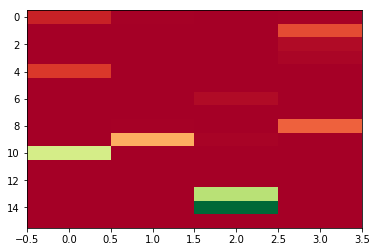

In [33]:
plt.imshow(Q, cmap='RdYlGn', aspect='auto')
plt.show()

**TODO** use the learned Q to do a few trials while printing the environment

## Part 2: Intro to TRFL with Approximate Q-Learning

### 2.1 What is TRFL and why?

*TRFL implements a large group of DRL building blocks including state-value learning, distributional-value learning, continuous-action policy gradient, deterministic policy gradient and many others.*

**TODO** complete using Blog post

### Value learning

- State Value learning:
**td_learning**
generalized_lambda_returns
td_lambda

- Discrete-action Value learning:
**qlearning**
double_qlearning
persistent_qlearning
sarsa
sarse
qlambda

- Distributional Value learning:
categorical_dist_qlearning
categorical_dist_double_qlearning
categorical_dist_td_learning

### Policy gradient
- Continuous-action Policy Gradient:
**policy_gradient**
policy_gradient_loss
policy_entropy_loss
sequence_a2c_loss

- Deterministic Policy Gradient:
dpg

- Discrete-action Policy Gradient:
**discrete_policy_entropy_loss**
sequence_advantage_actor_critic_loss: this is the commonly-used A2C/A3C loss function.
discrete_policy_gradient
discrete_policy_gradient_loss

### ... and a few other things

In [ ]:
# TODO

### 2.2 Installing

```pip install git+git://github.com/deepmind/trfl.git```

And the requirements:

```pip install tensorflow tensorflow-probability```

Note that you might still have some dependencies missing, for example `wrapt` was missing for me.

In [ ]:
import tensorflow as tf
import trfl

/Users/jeromekafrouni/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/jeromekafrouni/.pyenv/versions/3.6.1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/jeromekafrouni/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


### 2.3 Back to FrozenLake, with Approximate Q-Learning (and DQN)

We still want to solve the same problem, so the states and actions are the same.

Our goal also remains the same: learning the action value function Q(s,a) while interacting with the environment. Instead of learning the whole Q matrix (of shape (num_states,num_actions)), we want to learn an **approximate function (represented by a neural network) that takes as input (s,a) and outputs an approximation of the solution to the Bellman equation**.

As before, we will still choose an action a by taking the argmax of Q(s,a) for a given s.

Since the code gets a bit more complex, we introduce a class Agent for cleaner and more reusable code. Note that the way we interact with the environment stays very similar, only the training changes.

In [ ]:
def one_hot(n_classes, i):
    return np.eye(n_classes)[i].reshape(1,-1)

In [ ]:
# Set learning parameters
gamma = .99
eps = 0.1
num_episodes = 2000

In [ ]:
class Agent:
    # TODO implement batches
    def __init__(self, env, discount, eps, lr):
        self.env = env
        self.eps = eps # epsilon-greedy
        self.sess = tf.Session()
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.make_model(discount, lr)
        
    def make_model(self, discount, lr):
        self.state = tf.placeholder(shape=[1, self.n_states], dtype=tf.float32, name='state') # one hot encoding
        # W = tf.Variable(tf.random_uniform([self.n_states, self.n_actions], 0, 0.01))
        # self.Q = tf.matmul(self.state, W)
        dense = tf.layers.dense(self.state, 64, activation='relu')
        self.Q = tf.layers.dense(dense, self.n_actions, activation='linear')
        
        self.action = tf.placeholder(dtype=tf.int32, name='action')
        self.reward = tf.placeholder(dtype=tf.float32, name='reward')
        self.discount = tf.constant([discount])

        self.Q_target = tf.placeholder(dtype=tf.float32)
        loss, q_learning = trfl.qlearning(self.Q, self.action, self.reward, self.discount, self.Q_target)
        reduced_loss = tf.reduce_mean(loss)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.train_op = optimizer.minimize(reduced_loss)
    
    def predict(self, s):
        # TODO maybe launch session here instead of in train()
        return self.sess.run(self.Q, feed_dict={self.state: one_hot(self.n_states, s)})
    
    def act(self, s):
        Q = self.predict(s)
        if np.random.rand(1) < self.eps:
            a = [env.action_space.sample()]
        else:
            a = np.argmax(Q, 1)
        return a

    def train(self, num_episodes):
        episode_rewards = []
        with self.sess:
            self.sess.run(tf.global_variables_initializer())
            for i in range(num_episodes):
                episode_reward = 0
                # Reset environment and get first new observation
                s = self.env.reset()
                # The Q-Network
                for j in range(100):
                    a = self.act(s)
                    s1, r, done, _ = self.env.step(a[0])
                    episode_reward += r
                    if done and r != 1: # done early with no rewards means falling in a hole
                        r = -1
                    Q_target = self.predict(s1)
                    self.sess.run(self.train_op,
                                  {self.state: one_hot(self.n_states, s),
                                   self.Q_target: Q_target,
                                   self.action: a,
                                   self.reward: r})
                    s = s1
                    if done:
                        # TODO take care of update of eps if we call train multiple times?
                        # TODO discount eps differently
                        # Reduce chance of random action as we train the model.
                        # self.eps = 1./((i/50) + 10)
                        break
                episode_rewards.append(episode_reward)
                if i % 1000 == 0:
                    print('Episode %s done, average episode reward: %.2f %%' % (i, 100*np.mean(episode_rewards[-1000:]),))
        print("Percent of succesful episodes: %.2f %%" % (100*np.mean(episode_rewards),))
        return episode_rewards

**TODO train longer**

In [ ]:
agent = Agent(env, discount=0.99, eps=0.1, lr=0.1)
rewards = agent.train(2000)

Episode 0 done, average episode reward: 0.00 %
Episode 1000 done, average episode reward: 23.30 %
Percent of succesful episodes: 28.90 %


#### Switching from regular Q-learning to Sarsa:

Thanks to trfl, we can change our learning algorithm by only changing a few lines in the code. For example, we can use Sarsa:

In [ ]:
class SarsaAgent:
    # TODO implement batches
    def __init__(self, env, discount, eps, lr):
        self.env = env
        self.eps = eps # epsilon-greedy
        self.sess = tf.Session()
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.make_model(discount, lr)
        
    def make_model(self, discount, lr):
        self.state = tf.placeholder(shape=[1, self.n_states], dtype=tf.float32, name='state') # one hot encoding
        # W = tf.Variable(tf.random_uniform([self.n_states, self.n_actions], 0, 0.01))
        # self.Q = tf.matmul(self.state, W)
        dense = tf.layers.dense(self.state, 64, activation='relu')
        self.Q = tf.layers.dense(dense, self.n_actions, activation='linear')
        
        self.action = tf.placeholder(dtype=tf.int32, name='action')
        self.reward = tf.placeholder(dtype=tf.float32, name='reward')
        self.discount = tf.constant([discount])

        self.Q_target = tf.placeholder(dtype=tf.float32)
        self.action_target = tf.placeholder(dtype=tf.int32)
        loss, q_learning = trfl.sarsa(
            self.Q, self.action, self.reward, self.discount, self.Q_target, self.action_target)
        reduced_loss = tf.reduce_mean(loss)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        # this will update only W (because of how qlearning is implemented):
        self.train_op = optimizer.minimize(reduced_loss)
    
    def predict(self, s):
        # TODO maybe launch session here instead of in train()
        return self.sess.run(self.Q, feed_dict={self.state: one_hot(self.n_states, s)})
    
    def act(self, s):
        Q = self.predict(s)
        if np.random.rand(1) < self.eps:
            a = [env.action_space.sample()]
        else:
            a = np.argmax(Q, 1)
        return a

    def train(self, num_episodes):
        episode_rewards = []
        with self.sess:
            self.sess.run(tf.global_variables_initializer())
            for i in range(num_episodes):
                episode_reward = 0
                # Reset environment and get first new observation
                s = self.env.reset()
                # The Q-Network
                for j in range(100):
                    a = self.act(s)
                    s1, r, done, _ = self.env.step(a[0])
                    episode_reward += r
                    if done and r != 1: # done early with no rewards means falling in a hole
                        r = -1
                    Q_target = self.predict(s1)
                    action_target = self.act(s1)
                    self.sess.run(self.train_op,
                                  {self.state: one_hot(self.n_states, s),
                                   self.Q_target: Q_target,
                                   self.action: a,
                                   self.action_target: action_target,
                                   self.reward: r})
                    s = s1
                    if done:
                        # TODO take care of update of eps if we call train multiple times?
                        # TODO discount eps differently
                        # Reduce chance of random action as we train the model.
                        # self.eps = 1./((i/50) + 10)
                        break
                episode_rewards.append(episode_reward)
                if i % 1000 == 0:
                    print('Episode %s done, average episode reward: %.2f %%' % (i, 100*np.mean(episode_rewards[-1000:]),))
        print("Percent of succesful episodes: %.2f %%" % (100*np.mean(episode_rewards),))
        return episode_rewards

In [ ]:
sarsa_agent = SarsaAgent(env, discount=0.99, eps=0.1, lr=0.1)
rewards = sarsa_agent.train(2000)

Episode 0 done, average episode reward: 0.00 %
Episode 1000 done, average episode reward: 6.20 %
Percent of succesful episodes: 17.10 %


### Part 3: Going further, solving harder games

Above, we used approximate Q-learning on a game that didn't require it (because we could actually store and learn the full Q matrix). Now that we learned how to do that, we want to use Deep RL for when we actually need it: when the state and/or space action is too large to do tabular Q-learning

Let's choose a game a bit harder than FrozenLake but on which we can still easily train. What we'll do can extend easily to harder games, such as Atari games.

**TODO** complete

In [ ]:
env = gym.make('CartPole-v0')
env.action_space, env.observation_space

/Users/jeromekafrouni/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(Discrete(2), Box(4,))

**TODO** print inline

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

There are only two actions: pushing left or right (+1 or -1), but the state space is now continuous, described by 4 variables: x, x', theta, theta'.

We would easily adapt our previous agent's architecture for this task: the only thing to change is how the states are encoded (used to be one-hot encoded).

In [ ]:
# TODO maybe?

Let's use policy-gradient methods instead to learn how to use them in TRFL:

Now we need to use the current policy over one episode, collect all the rewards, the over that replay compute the values of each step (now that we know the horizon). And then pass it to trfl.

In [ ]:
class PolicyGradientAgent:
    # TODO implement batches
    def __init__(self, env, discount, eps, lr):
        self.env = env
        self.eps = eps # epsilon-greedy
        self.sess = tf.Session()
        self.dim_state = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.discount = discount
        self.make_model(lr)
        
    def make_model(self, lr):
        self.state = tf.placeholder(shape=[1, self.dim_state], dtype=tf.float32, name='state')
        dense = tf.layers.dense(self.state, 50, activation='relu')
        # dense = tf.layers.dense(dense, 12, activation='relu')
        self.policy = tf.layers.dense(dense, self.n_actions, activation='softmax')
        
        # self.replay_states = tf.placeholder(dtype=tf.float32, name='replay_states')
        self.replay_action = tf.placeholder(dtype=tf.int32, name='replay_action')
        self.replay_value = tf.placeholder(dtype=tf.float32, name='replay_value')
        
        loss = trfl.discrete_policy_gradient(self.policy, # TODO try to do the whole batch at once
                                             self.replay_action,
                                             self.replay_value)
        reduced_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.train_op = optimizer.minimize(reduced_loss)
    
    def predict(self, s):
        # TODO maybe launch session here instead of in train()
        return self.sess.run(self.policy, feed_dict={self.state: s.reshape(1,-1)})
    
    def act(self, s):
        p = self.predict(s)
        p = p/p.sum() # trick to normalize p for very small precision issues
        if np.random.rand(1) < self.eps:
            a = [env.action_space.sample()]
        else:
            # a = np.argmax(p, 1)
            a = [np.random.choice(range(p.shape[1]), p=p.ravel())]
        return a
    
    def compute_values(self, rewards):
        """
        Given all the rewards received during one episode, compute the value
        of each action.
        """
        values = [0] * len(rewards)
        rewards.reverse()
        for i, r in enumerate(rewards):
            values[i] = r + self.discount * values[i-1]
        values.reverse()
        return values

    def train(self, num_episodes):
        episode_rewards = []
        with self.sess:
            self.sess.run(tf.global_variables_initializer())
            for i in range(num_episodes):
                states, actions, rewards = [], [], []
                # Reset environment and get first new observation
                s = self.env.reset()
                # The Q-Network
                done = False
                while not done:
                    # we don't train at each timestep anymore,
                    # we use the same policy throughout one episode
                    # and then use the 'replay' to learn
                    a = self.act(s)
                    s1, r, done, _ = self.env.step(a[0])
                    # store replay:
                    states.append(s)
                    actions.append(a)
                    rewards.append(r)
                    
                    s = s1
                # now use the replay of that episode to train:
                values = self.compute_values(rewards)
                for s, a, v in zip(states, actions, values):
                    # TODO try to do the whole batch at once
                    self.sess.run(self.train_op,
                                  {self.state: s.reshape(1,-1),
                                   self.replay_action: a,
                                   self.replay_value: np.array([v])})
                episode_rewards.append(sum(rewards))
                if i % 100 == 0:
                    print("Episode %s, Average reward per episode: %.2f" % (i, np.mean(episode_rewards[-100:]),))
                    print(self.predict(s))
        return episode_rewards

In [ ]:
policy_agent = PolicyGradientAgent(env, discount=0.99, eps=0.1, lr=0.001)
rewards = policy_agent.train(2000)

Episode 0, Average reward per episode: 15.00
[[0.52634764 0.47365236]]
Episode 100, Average reward per episode: 46.45
[[0.9919084  0.00809162]]
Episode 200, Average reward per episode: 82.35
[[0.01836267 0.9816373 ]]
Episode 300, Average reward per episode: 105.01
[[1.000000e+00 8.861978e-12]]
Episode 400, Average reward per episode: 97.84
[[4.436048e-10 1.000000e+00]]
Episode 500, Average reward per episode: 78.94
[[1.0970825e-09 1.0000000e+00]]
Episode 600, Average reward per episode: 65.18
[[3.073839e-04 9.996927e-01]]
Episode 700, Average reward per episode: 66.55
[[9.999999e-01 7.442094e-08]]
Episode 800, Average reward per episode: 65.33
[[5.262675e-10 1.000000e+00]]
Episode 900, Average reward per episode: 70.74
[[1.7775509e-09 1.0000000e+00]]
Episode 1000, Average reward per episode: 74.59
[[3.1439915e-10 1.0000000e+00]]
Episode 1100, Average reward per episode: 68.75
[[7.0573833e-06 9.9999297e-01]]
Episode 1200, Average reward per episode: 75.74
[[1.8587718e-07 9.9999976e-01]]